# 读取数据

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import pandas as pd
sns.set_style('white')

In [3]:
data_folder = os.path.join('..', '数据', '最大气泡法')

In [4]:
data = {}
dataset = {25, 35}
for t in dataset:
    data[t] = pd.read_csv(os.path.join(data_folder, f"{t}.csv"), index_col=0)

In [5]:
data[25].head()

,1,2,3
c,,,
0.0000,795,797,798
0.0125,782,782,783
0.0250,762,762,761
0.0500,671,672,672
0.1000,617,619,619


In [6]:
data[35].head()

,1,2,3
c,,,
0.0000,820,823,825
0.0125,795,796,798
0.0250,771,773,770
0.0500,720,719,721
0.1000,648,647,649


# 数据处理



## 平均值

In [7]:
# 计算平均值
for t in dataset:
    data[t]['P'] = data[t][data[t].columns].mean(axis=1)

data[25]

,1,2,3,P
c,,,,
0.0000,795,797,798,796.666667
0.0125,782,782,783,782.333333
0.0250,762,762,761,761.666667
0.0500,671,672,672,671.666667
0.1000,617,619,619,618.333333
0.2000,527,526,527,526.666667
0.3000,472,470,412,451.333333
0.4000,414,412,414,413.333333
0.5000,377,378,378,377.666667


## 毛细管常数$K$

$$
\sigma = K \Delta P
$$

$$
\sigma _1 = 71.97 \times 10^{-3} \mathrm{N} \cdot \mathrm{m^{-1}}
$$

$$
\sigma _2 = 70.38 \times 10^{-3} \mathrm{N} \cdot \mathrm{m^{-1}}
$$

In [8]:
sigma_water = {
    25: 71.97 * 10 ** -3,
    35: 70.38 * 10 ** -3,
} # 纯水的表面张力
K = {}
for t in dataset:
    K[t] = sigma_water[t] / data[t].iloc[0]["P"]
K

{25: 9.033891213389122e-05, 35: 8.555105348460292e-05}

## 溶液的表面张力

In [9]:
for t in dataset:
    data[t]['sigma'] = K[t] * data[t]['P']
data[25]

,1,2,3,P,sigma
c,,,,,
0.0000,795,797,798,796.666667,0.071970
0.0125,782,782,783,782.333333,0.070675
0.0250,762,762,761,761.666667,0.068808
0.0500,671,672,672,671.666667,0.060678
0.1000,617,619,619,618.333333,0.055860
0.2000,527,526,527,526.666667,0.047578
0.3000,472,470,412,451.333333,0.040773
0.4000,414,412,414,413.333333,0.037340
0.5000,377,378,378,377.666667,0.034118


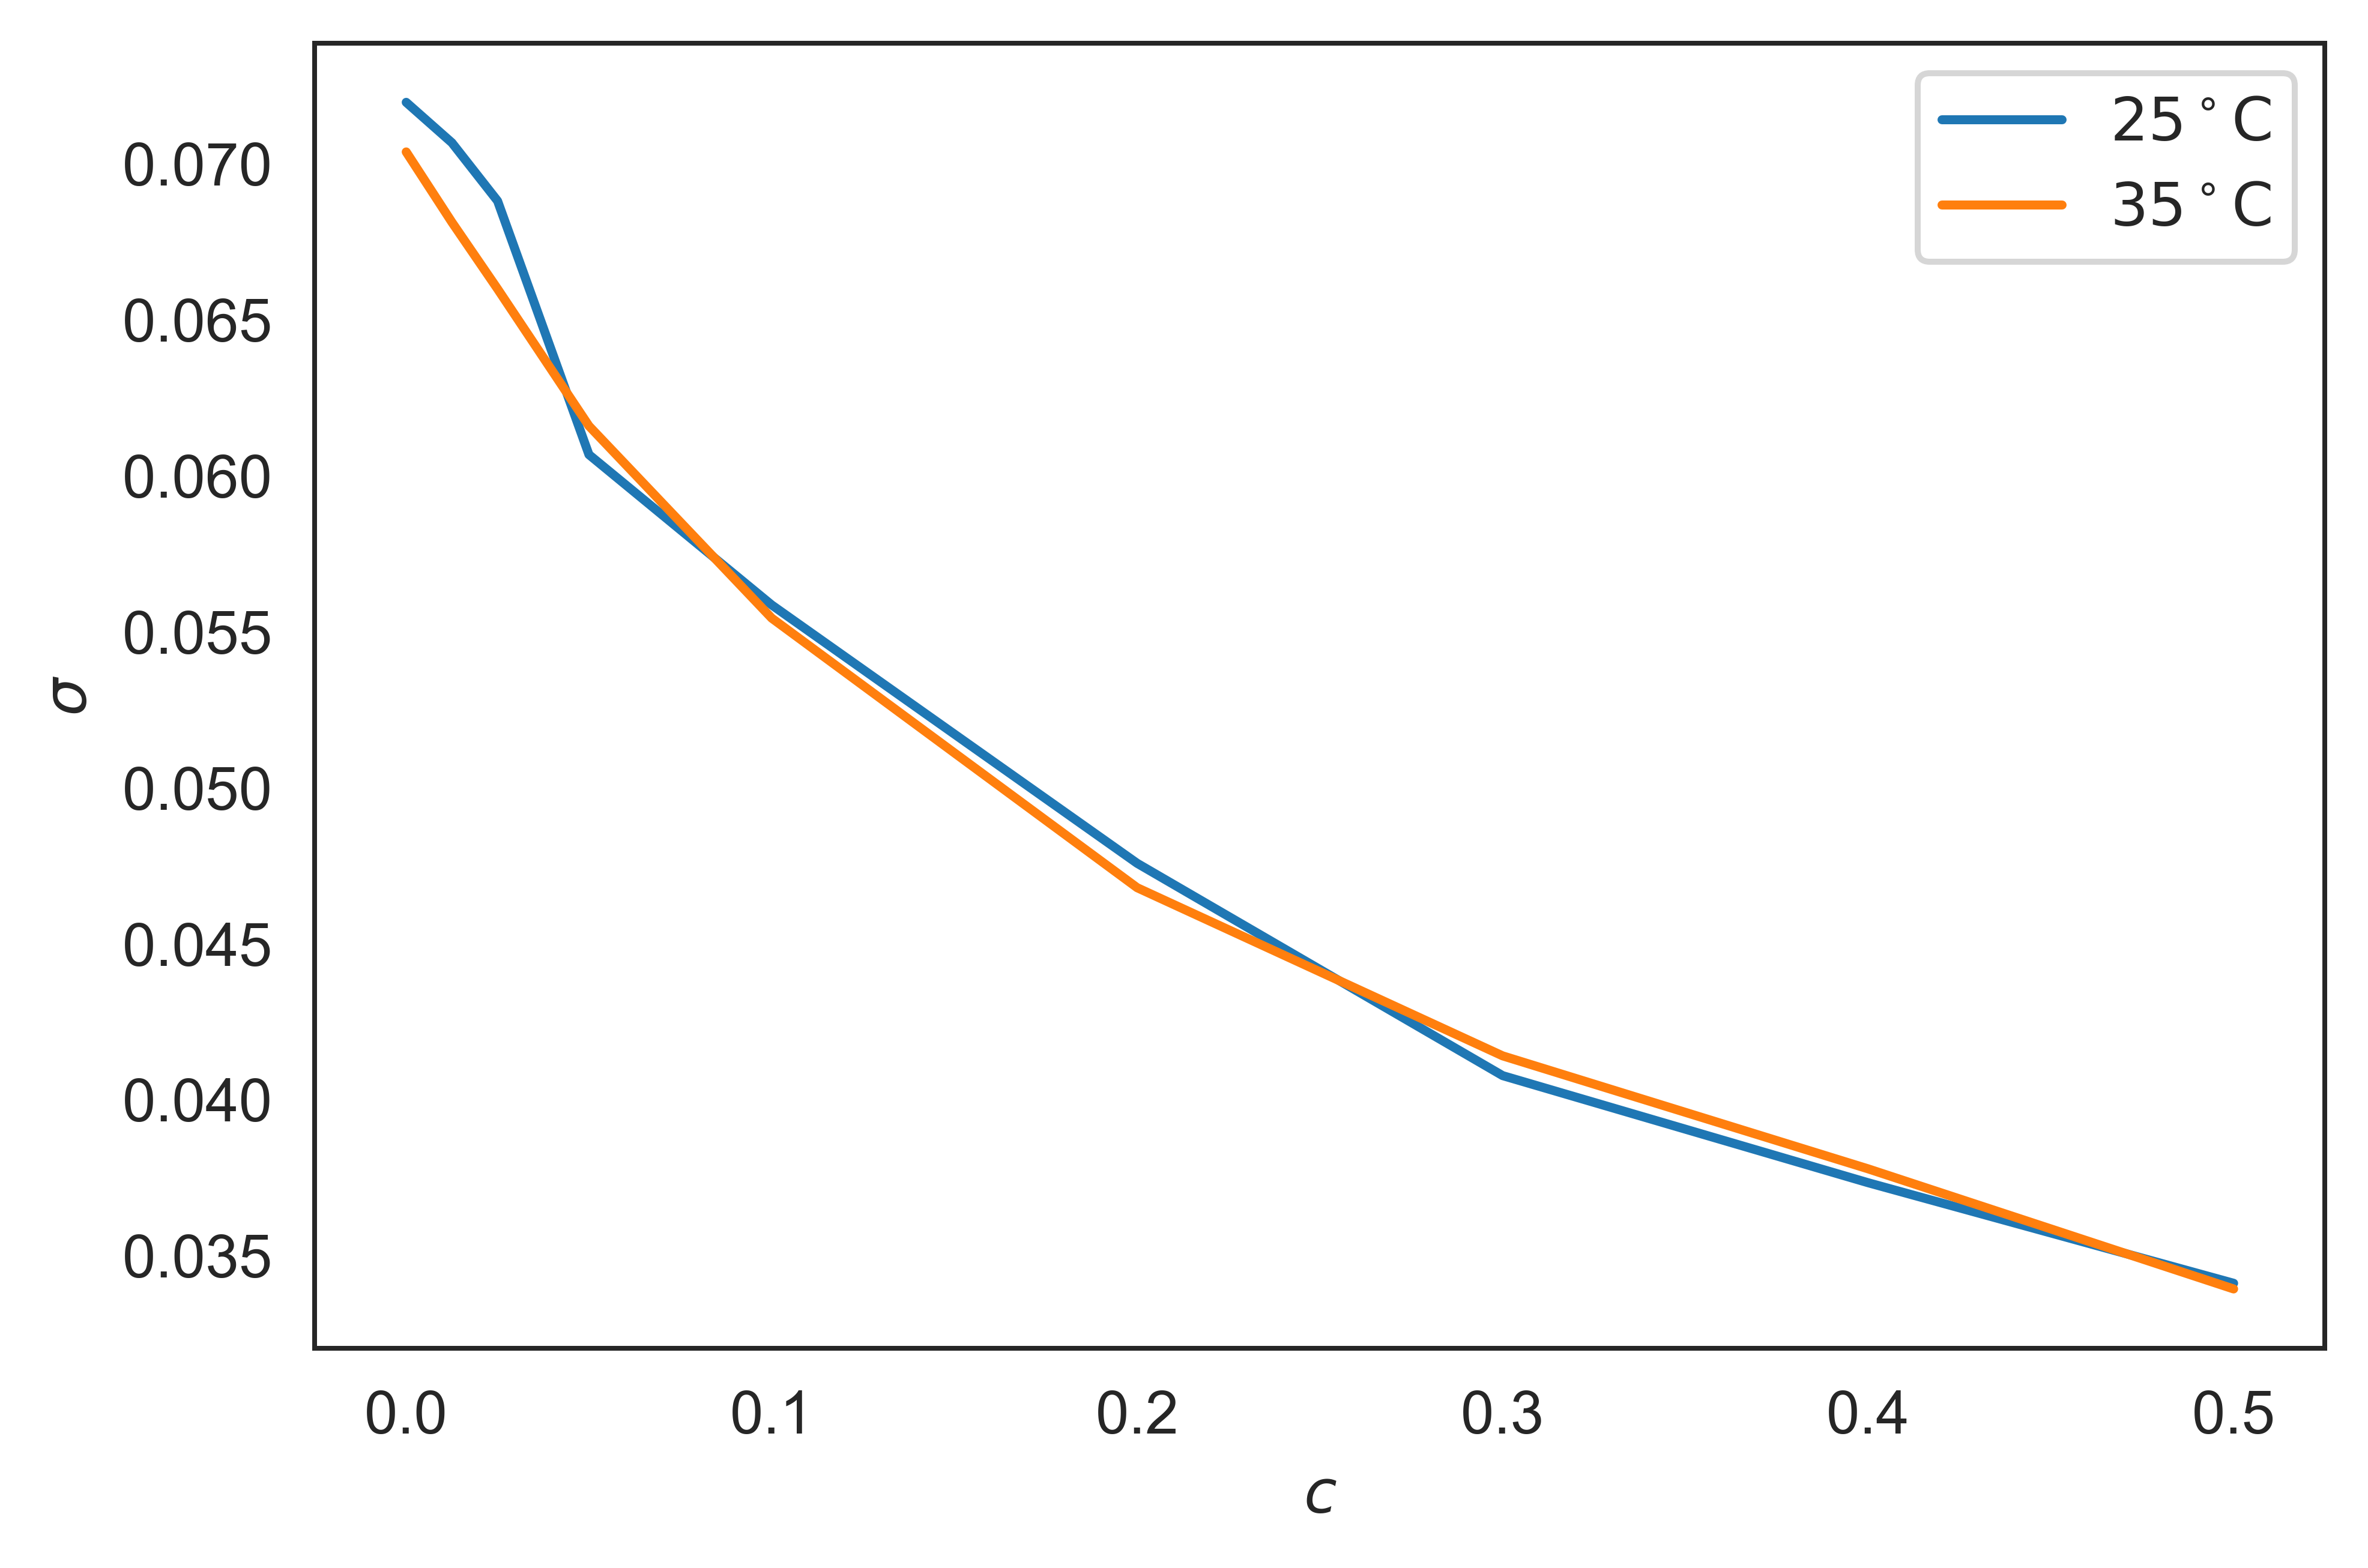

In [10]:
# 作图
fig, ax = plt.subplots(1, 1, dpi=720)
for t in dataset:
    ax.plot(data[t].index, data[t]['sigma'], label=r"$%d^\circ \mathrm{C}$" % t)
    ax.set_xlabel('$c$')
    ax.set_ylabel('$\sigma$')
ax.legend()

## 计算$\Gamma$值

$$
\Gamma = -\frac{c}{RT} \left( \frac{\partial \sigma}{\partial c} \right)_T
$$

为了严格结果，我们必须选择合理的拟合曲线。

我查阅文献，发现表面张力与浓度有经验公式(Szyszkowski公式)：

$$
    \frac{\sigma_0 - \sigma}{\sigma_0} = b \ln \left( 1 + \frac{c}{a}\right)
$$

即

$$
\sigma = \sigma_0 - b \ln \left( 1 + \frac{c}{a}\right) \cdot \sigma_0
$$

In [11]:
def szyszkowski(c, sigma0, a, b):
    return sigma0 - b * np.log(1 + c / a) * sigma0

def szyszkowski1(c, sigma0, a, b):
    return - b * sigma0 / (a + c)

In [12]:
popt, pcov = {}, {}
for t in dataset:
    popt[t], pcov[t] = curve_fit(szyszkowski, data[t].index, data[t]['sigma'], bounds=(0, np.inf))

## 用拟合的参数作图

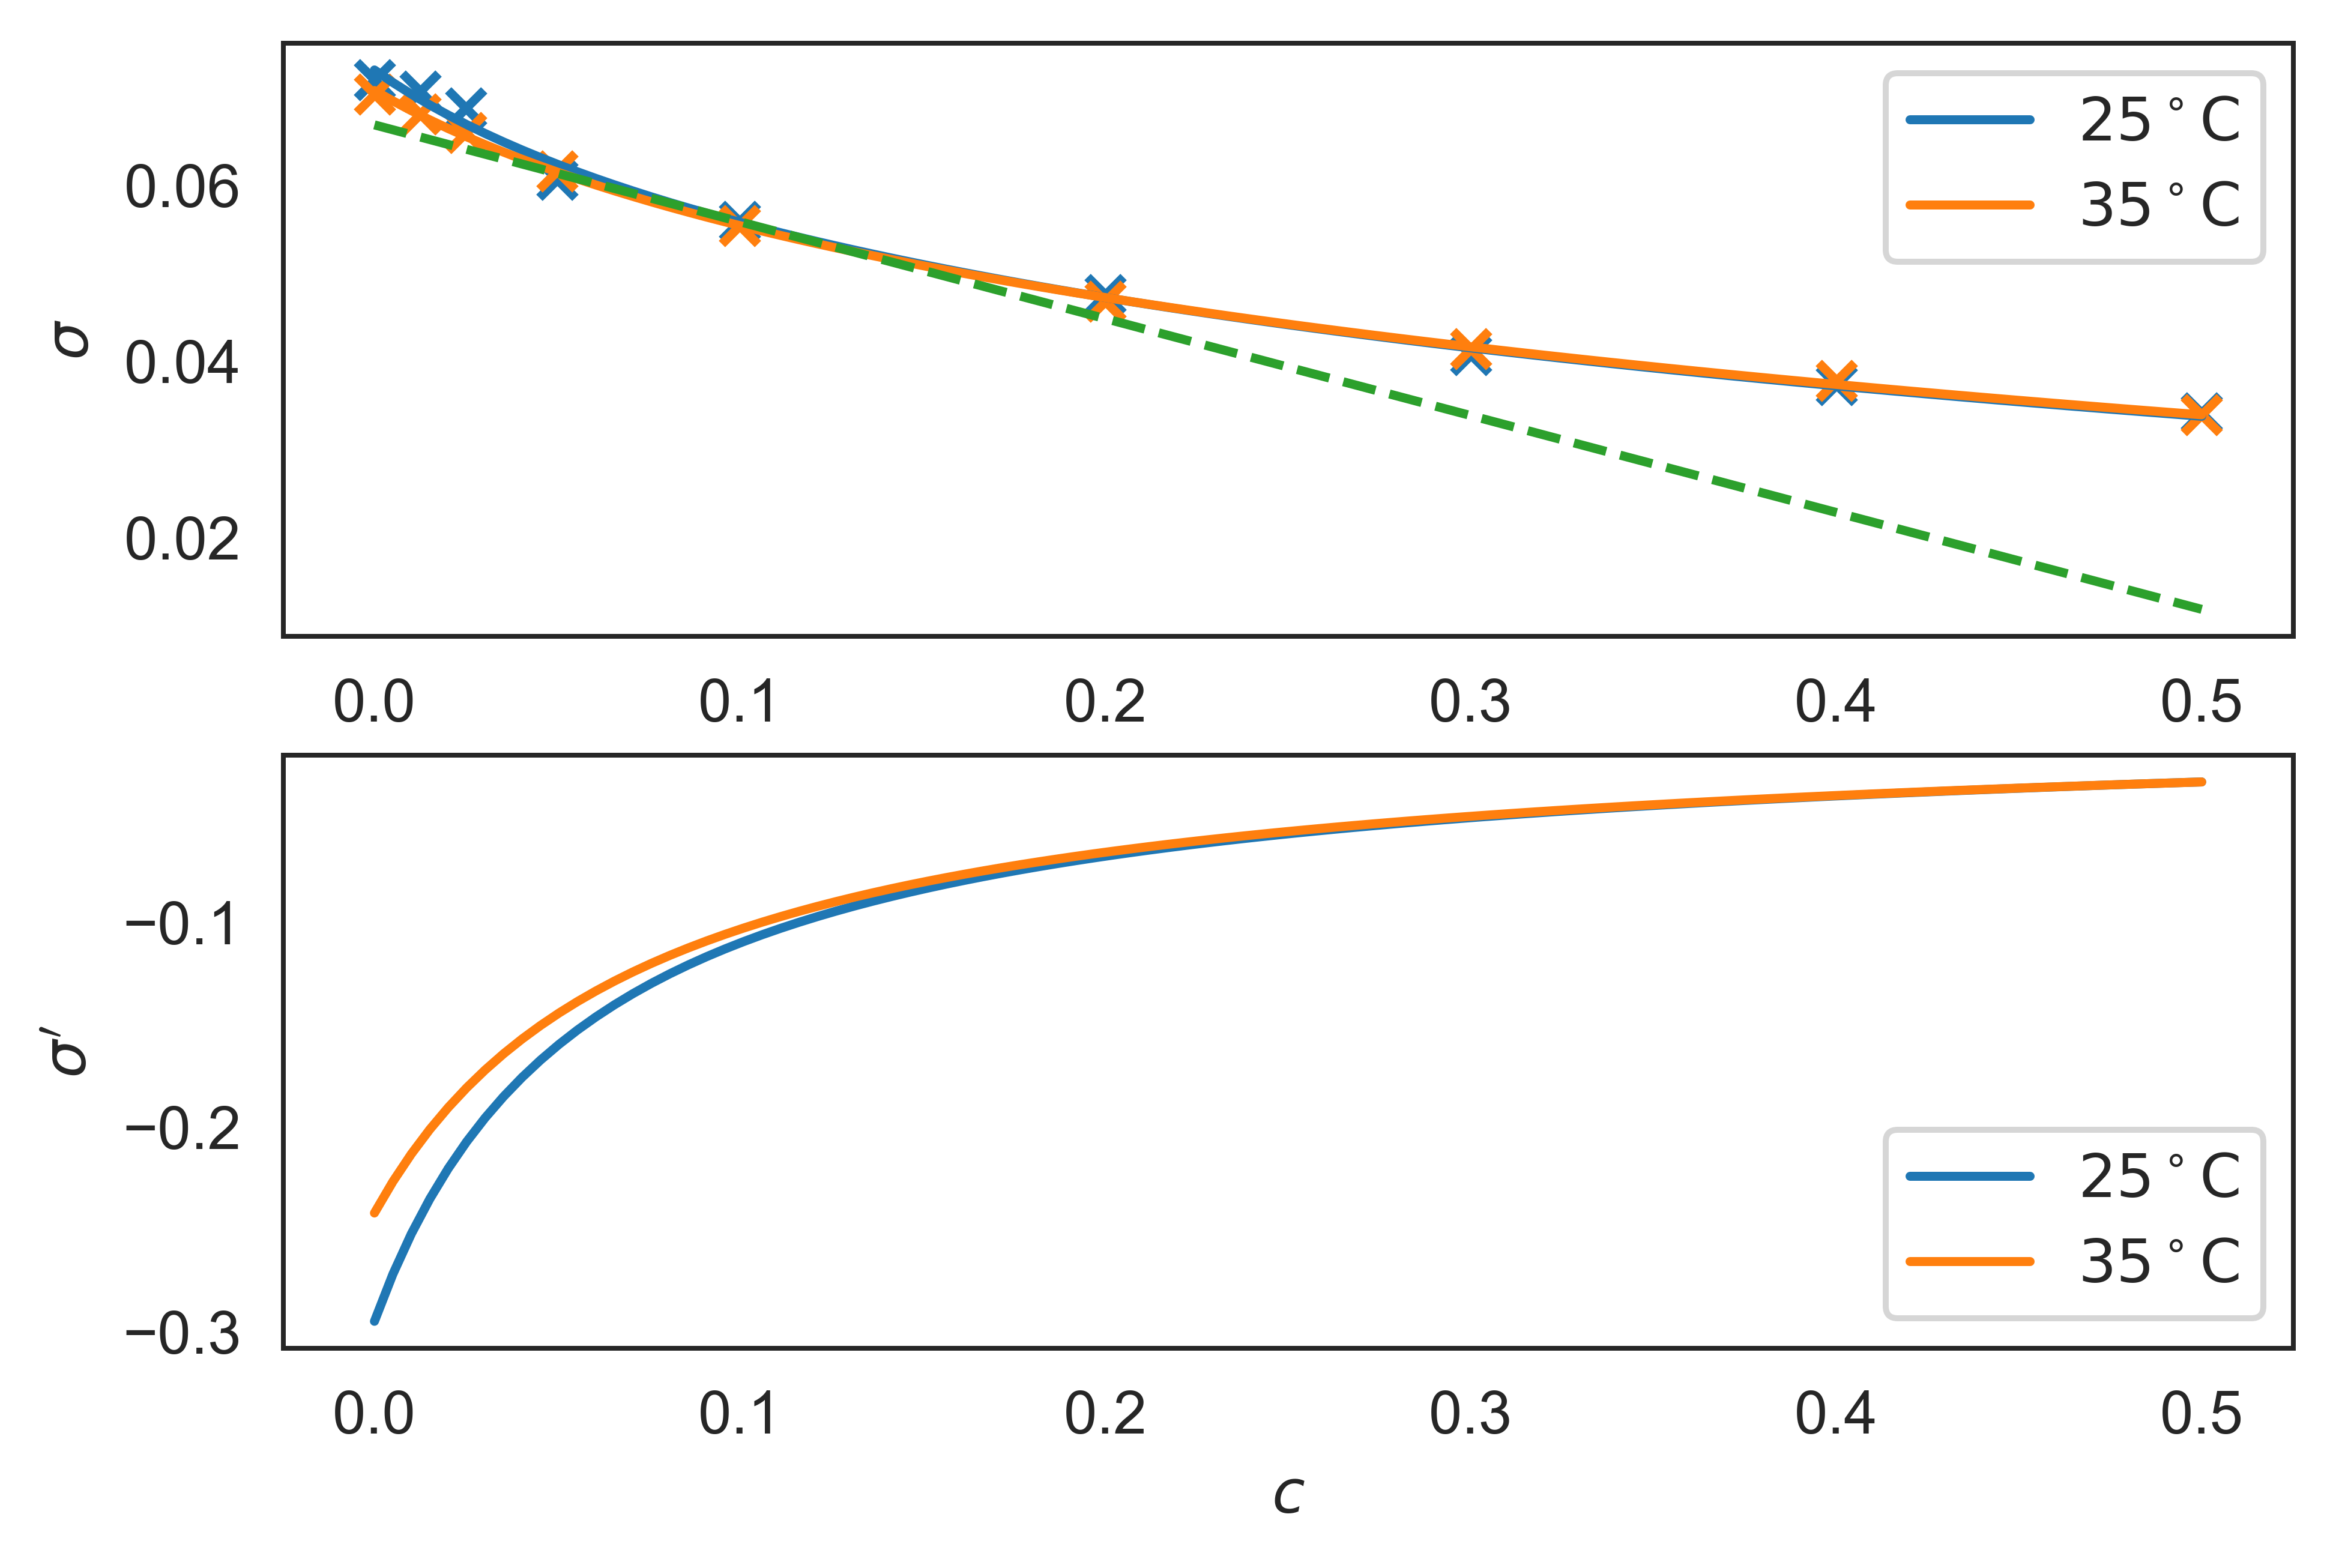

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=720)
c = np.linspace(0, 0.5, 100)
for t in dataset:
    ax1.scatter(data[t].index, data[t]['sigma'], marker='x')
    ax1.set_xlabel(r'$c$')
    ax1.set_ylabel(r'$\sigma$')
    ax2.set_xlabel(r'$c$')
    ax2.set_ylabel(r"$\sigma '$")
    ax1.plot(c, szyszkowski(c, *popt[t]), label=r'$%s^\circ \mathrm{C}$' % t)
    ax2.plot(c, szyszkowski1(c, *popt[t]), label=r'$%s^\circ \mathrm{C}$' % t)
cc = 0.1
ax1.legend()
ax2.legend()
kk = szyszkowski1(cc, *popt[25])
bb = data[25]['sigma'][cc] - kk * cc
ax1.plot(c, kk * c + bb, '--')

### $\Gamma$

In [16]:
gamma = {}
from scipy.constants import R
T = 298 # K
for t in dataset:
    gamma[t] = - c / (R * T) * szyszkowski1(c, *popt[t])

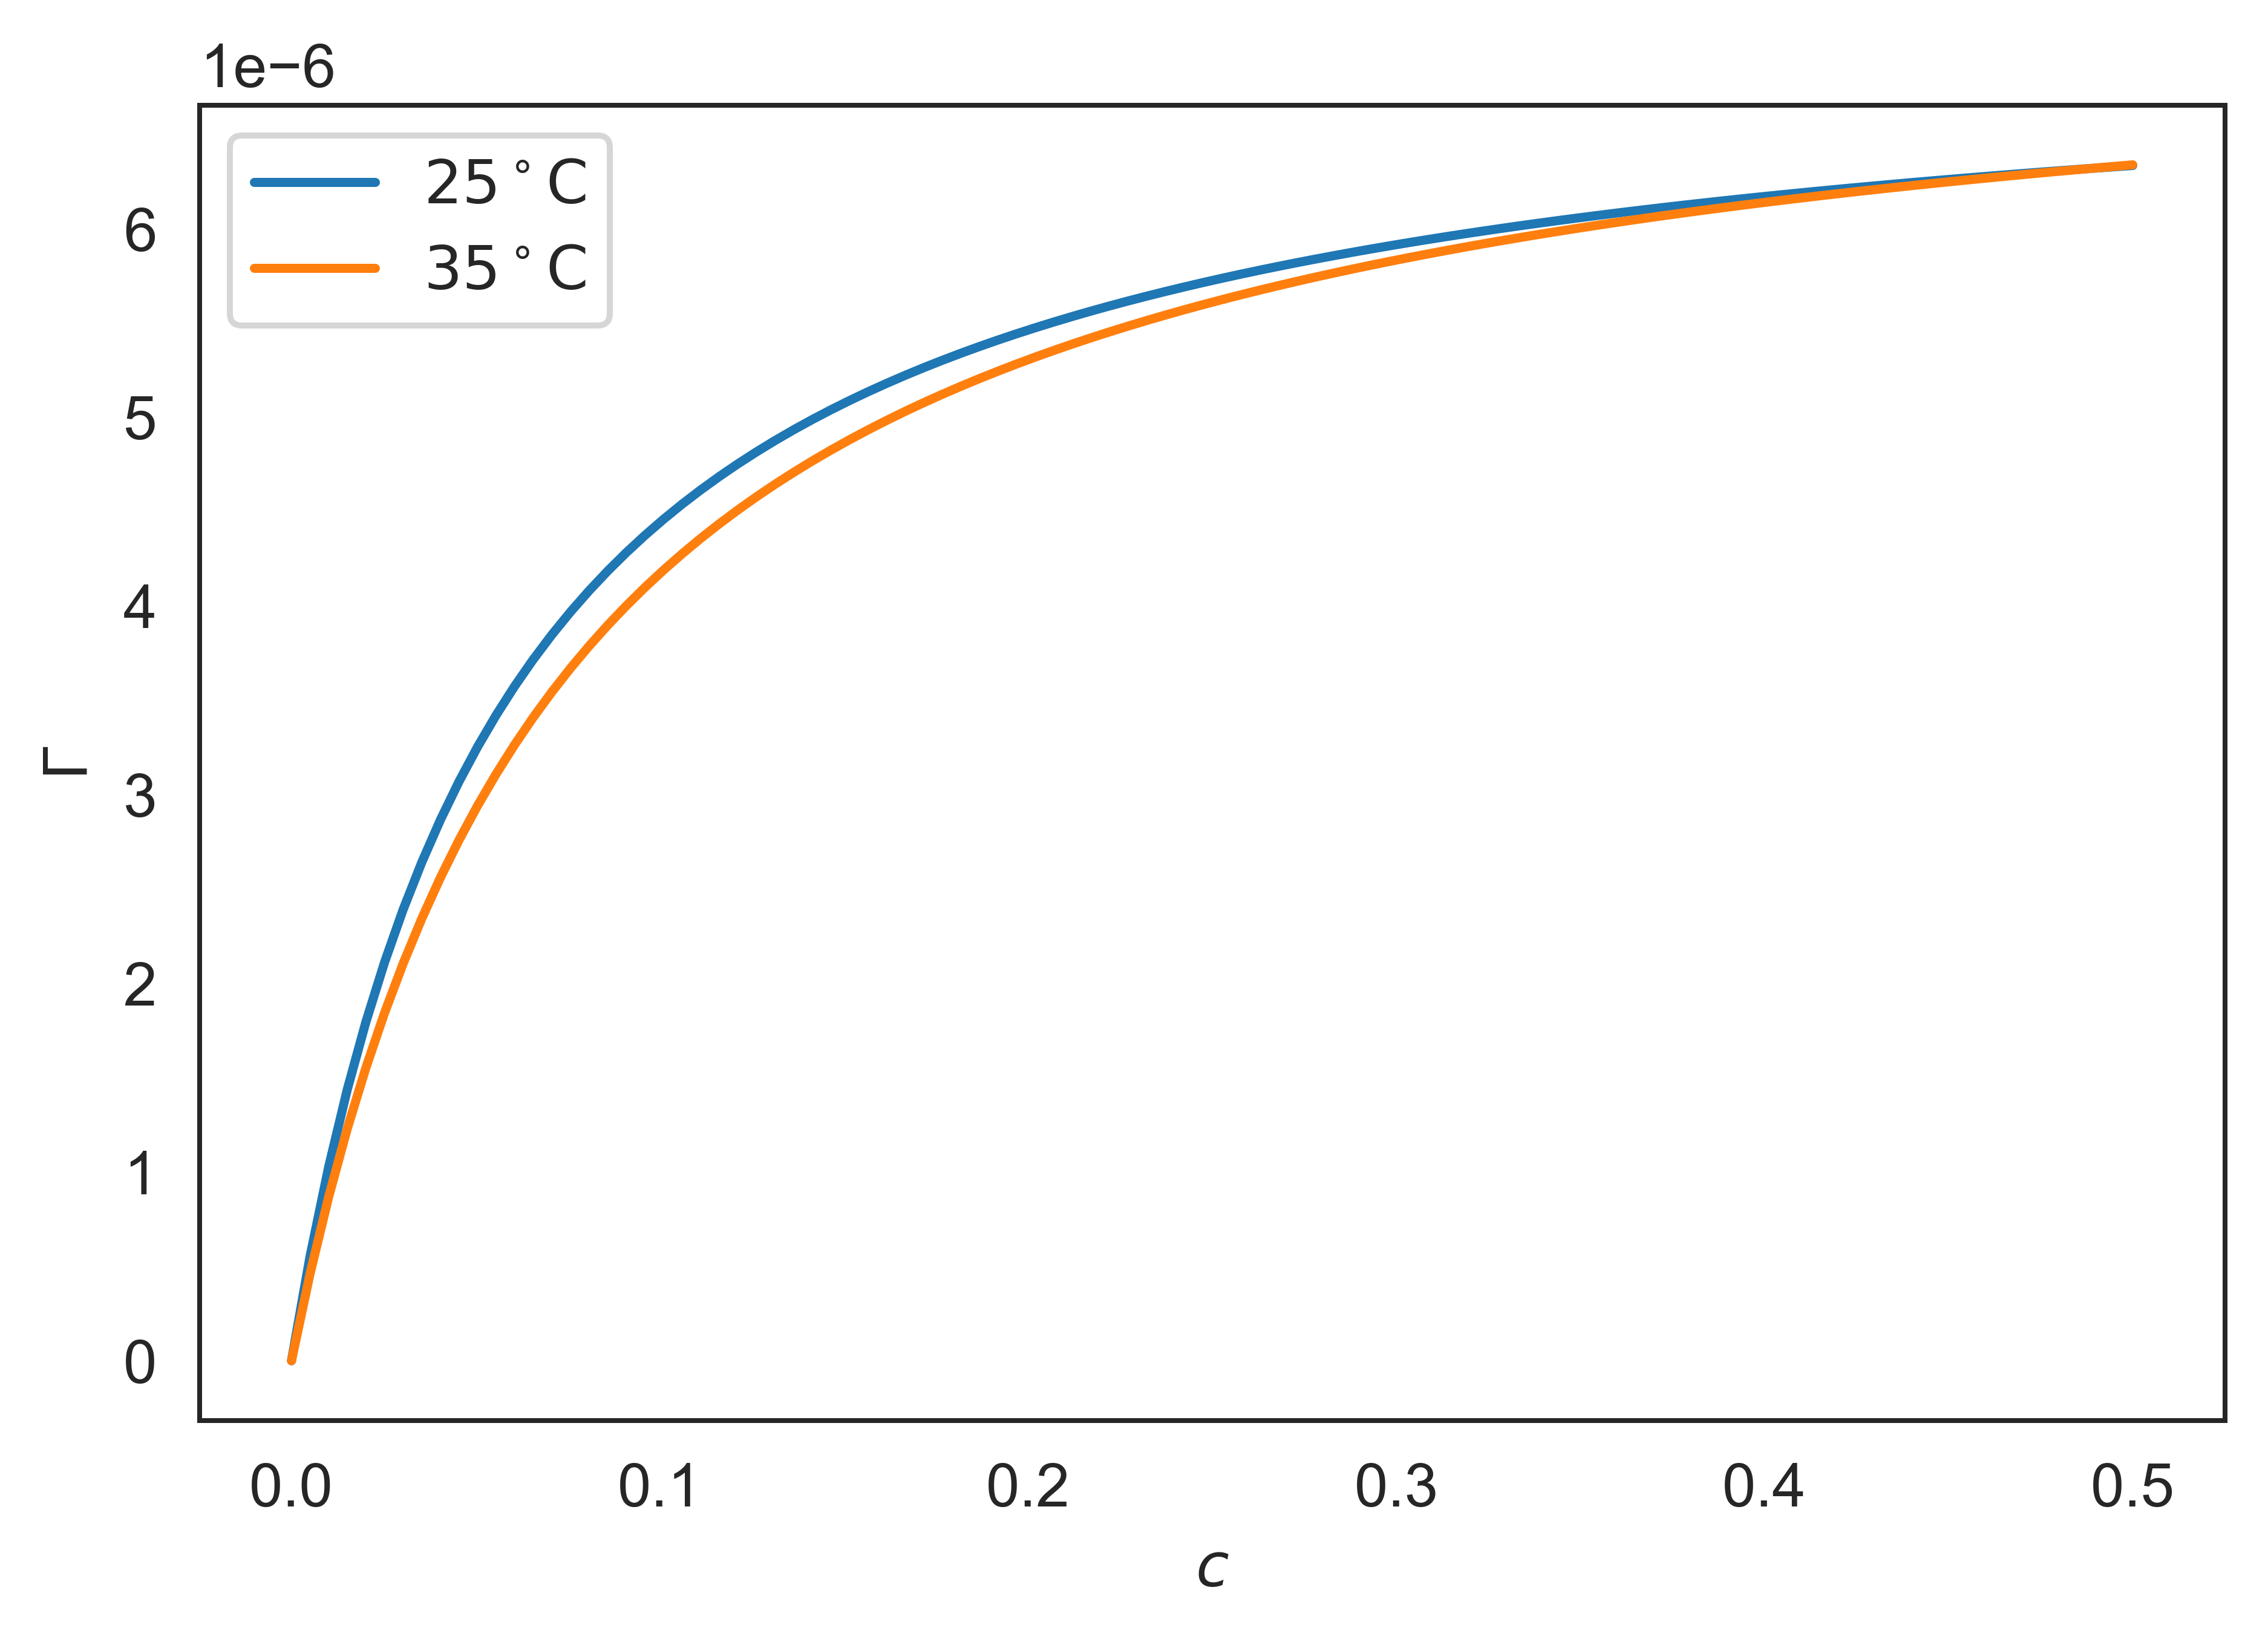

In [20]:
fig, ax = plt.subplots(dpi=720)
for t in dataset:
    ax.plot(c, gamma[t], label=r'$%s^\circ \mathrm{C}$' % t)
ax.set_xlabel(r'$c$')
ax.set_ylabel(r'$\Gamma$')
ax.legend()